**Automatic Ticket Assignment - Capstone Project**

Problem Statement - 

In most of the IT organizations, the assignment of incidents to appropriate IT groups is still a manual process. Manual assignment of incidents is time consuming and requires human efforts. There may be mistakes due to human errors and resource consumption is carried out ineffectively because of the misaddressing. On the other hand, manual assignment increases the response and resolution times which result in user satisfaction deterioration / poor customer service.

This capstone project intends to reduce the manual intervention of IT operations or Service desk teams by automating the ticket assignment process.The goal here is to create a text classification based ML model that can automatically classify any new tickets by analysing ticket description to one of the relevant Assignment groups, which could be later integrated to any ITSM tool like Service Now. Based on the ticket description our model will output the probability of assigning it to one of the 74 Groups.

**Import necessary libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = None

**Loading Data**

In [2]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Setting the current working directory
import os; os.chdir('drive/My Drive/Colab Notebooks/Data_NLP')

In [4]:
pip install polyglot

In [5]:
pip install ftfy


In [6]:
pip install icu

**A quick look at our data and inspect
Read the data using pandas read_excel**

In [7]:
df2 = pd.read_excel("input_data.xlsx")

In [8]:
df2.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


**Shape of the data**

In [9]:
df2.shape

(8500, 4)

**Dropping caller column as it doesnot impact the tickets in anyway**

In [10]:
df2.drop(columns='Caller',inplace=True)
df2.head()

,Short description,Description,Assignment group
0,login issue,-verified user details.(employee# & manager na...,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,GRP_0
4,skype error,skype error,GRP_0


In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Assignment group   8500 non-null   object
dtypes: object(3)
memory usage: 199.3+ KB


**Observation**:¶
There are 4 columns and all are string columns

There are totally 8500 rows and there seems to be mising values in Short

Assignment group is our predictor / target column with multiple classes.
This is a Multiclass Classification problem

**Lets see the number of classes in the Assignment group**

In [12]:
df2['Assignment group'].unique()

array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'GRP_35', 'GRP_36', 'GRP_37', 'GRP_38',
       'GRP_39', 'GRP_40', 'GRP_41', 'GRP_42', 'GRP_43', 'GRP_44',
       'GRP_45', 'GRP_46', 'GRP_47', 'GRP_48', 'GRP_49', 'GRP_50',
       'GRP_51', 'GRP_52', 'GRP_53', 'GRP_54', 'GRP_55', 'GRP_56',
       'GRP_57', 'GRP_58', 'GRP_59', 'GRP_60', 'GRP_61', 'GRP_32',
       'GRP_62', 'GRP_63', 'GRP_64', 'GRP_65', 'GRP_66', 'GRP_67',
       'GRP_68', 'GRP_69', 'GRP_70', 'GRP_71', 'GRP_72', 'GRP_73'],
      dtype=object)

In [13]:
len(df2['Assignment group'].unique())

74

** The Assigment group contains 74 different classes**

In [14]:
df_inc = df2['Assignment group'].value_counts().reset_index()
df_inc['percentage'] = (df_inc['Assignment group']/df_inc['Assignment group'].sum())*100
df_inc.head()

,index,Assignment group,percentage
0,GRP_0,3976,46.776471
1,GRP_8,661,7.776471
2,GRP_24,289,3.400000
3,GRP_12,257,3.023529
4,GRP_9,252,2.964706


**Visualizing the percentage wise data**

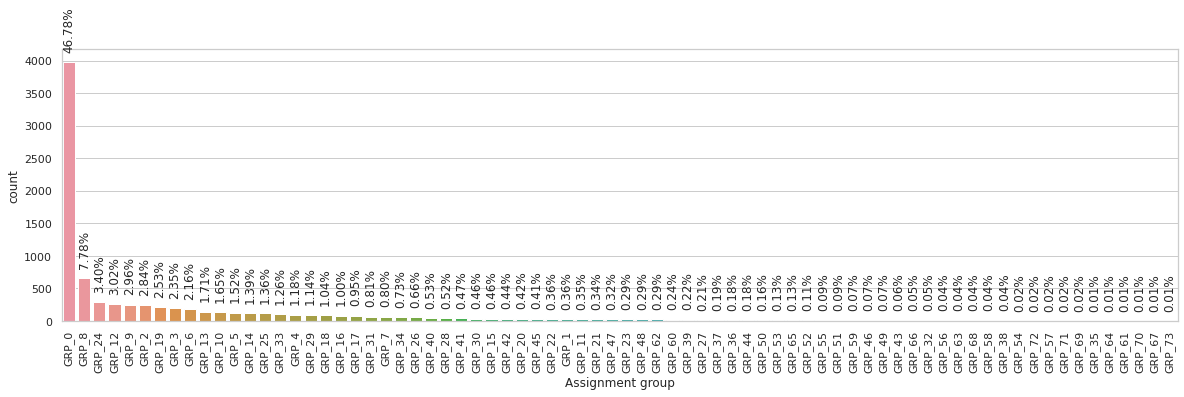

In [15]:
# Plot to visualize the percentage data distribution across different groups
sns.set(style="whitegrid")
plt.figure(figsize=(20,5))
ax = sns.countplot(x="Assignment group", data=df2, order=df2["Assignment group"].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
  ax.annotate(str(format(p.get_height()/len(df2.index)*100, '.2f')+"%"), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'bottom', rotation=90, xytext = (0, 10), textcoords = 'offset points')

Observation This is a imbalanced dataset, with majority of incidents are from Group 0 followed by Group 8 , 24 , 12 , 9 , 2 and so on

There are few classes which just have less 10 incidents pers class and even classed with just 1 or 2 incidents, need to see if we can drop those rows due

to the lack of samples representing those classes. They might not be of much help as a predictor

# New Section

In [16]:
df_top_20 = df2['Assignment group'].value_counts().nlargest(20).reset_index()
df_top_20

,index,Assignment group
0,GRP_0,3976
1,GRP_8,661
2,GRP_24,289
3,GRP_12,257
4,GRP_9,252
5,GRP_2,241
6,GRP_19,215
7,GRP_3,200
8,GRP_6,184
9,GRP_13,145


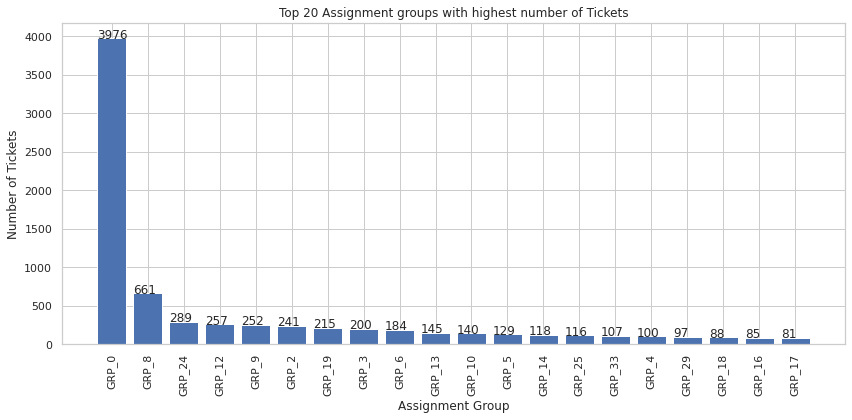

In [17]:
plt.figure(figsize=(12,6))
bars = plt.bar(df_top_20['index'],df_top_20['Assignment group'])
plt.title('Top 20 Assignment groups with highest number of Tickets')
plt.xlabel('Assignment Group')
plt.xticks(rotation=90)
plt.ylabel('Number of Tickets')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .005, yval)
plt.tight_layout()
plt.show()

**Distribution of tickets counts in various bins**

In [18]:
df_bins = pd.DataFrame(columns=['Description','Ticket Count'])
one_ticket = {'Description':'1 ticket','Ticket Count':len(df_inc[df_inc['Assignment group'] < 2])}
_2_5_ticket = {'Description':'2-5 ticket',
              'Ticket Count':len(df_inc[(df_inc['Assignment group'] > 1)& (df_inc['Assignment group'] < 6) ])}
_10_ticket = {'Description':' 6-10 ticket',
              'Ticket Count':len(df_inc[(df_inc['Assignment group'] > 5)& (df_inc['Assignment group'] < 11)])}
_10_20_ticket = {'Description':' 11-20 ticket',
              'Ticket Count':len(df_inc[(df_inc['Assignment group'] > 10)& (df_inc['Assignment group'] < 21)])}
_20_50_ticket = {'Description':' 21-50 ticket',
              'Ticket Count':len(df_inc[(df_inc['Assignment group'] > 20)& (df_inc['Assignment group'] < 51)])}
_51_100_ticket = {'Description':' 51-100 ticket',
              'Ticket Count':len(df_inc[(df_inc['Assignment group'] > 50)& (df_inc['Assignment group'] < 101)])}
_100_ticket = {'Description':' >100 ticket',
              'Ticket Count':len(df_inc[(df_inc['Assignment group'] > 100)])}
#append row to the dataframe
df_bins = df_bins.append([one_ticket,_2_5_ticket,_10_ticket,
                          _10_20_ticket,_20_50_ticket,_51_100_ticket,_100_ticket], ignore_index=True)

In [19]:
df_bins

,Description,Ticket Count
0,1 ticket,6
1,2-5 ticket,13
2,6-10 ticket,6
3,11-20 ticket,9
4,21-50 ticket,16
5,51-100 ticket,9
6,>100 ticket,15


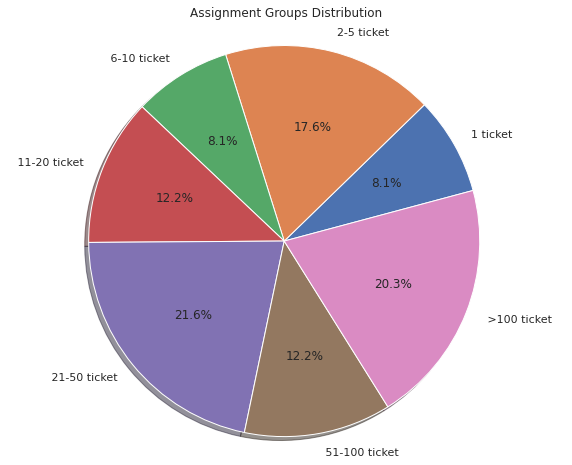

In [20]:
plt.figure(figsize=(10, 8))
plt.pie(df_bins['Ticket Count'],labels=df_bins['Description'],autopct='%1.1f%%', startangle=15, shadow = True);
plt.title('Assignment Groups Distribution')
plt.axis('equal');

We see that there are 6 Assignment Group’s for which just have 1 ticket in the dataset

There are 15 Assignment group’s which have more than 100 tickets.

Only 20% of the Assignment groups have greater than 100 tickets.

In [21]:
df2[df2['Short description'].isnull()]

,Short description,Description,Assignment group
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,GRP_34
3383,NaN,\r\n-connected to the user system using teamvi...,GRP_0
3906,NaN,-user unable tologin to vpn.\r\n-connected to...,GRP_0
3910,NaN,-user unable tologin to vpn.\r\n-connected to...,GRP_0
3915,NaN,-user unable tologin to vpn.\r\n-connected to...,GRP_0
3921,NaN,-user unable tologin to vpn.\r\n-connected to...,GRP_0
3924,NaN,name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...,GRP_0
4341,NaN,\r\n\r\nreceived from: eqmuniov.ehxkcbgj@gmail...,GRP_0


 Replace null values with short_description + description and assign as new description


In [22]:
#Replace NaN values in Short Description and Description columns
df2['Short description'] = df2['Short description'].replace(np.nan, '', regex=True)
df2['Description'] = df2['Description'].replace(np.nan, '', regex=True)

In [23]:
#Concatenate Short Description and Description columns
df2['New_Description'] = df2['Short description'] + ' ' +df2['Description']

In [24]:
df2.head()

,Short description,Description,Assignment group,New_Description
0,login issue,-verified user details.(employee# & manager na...,GRP_0,login issue -verified user details.(employee# ...
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,GRP_0,outlook \r\n\r\nreceived from: hmjdrvpb.komuay...
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,GRP_0,cant log in to vpn \r\n\r\nreceived from: eylq...
3,unable to access hr_tool page,unable to access hr_tool page,GRP_0,unable to access hr_tool page unable to access...
4,skype error,skype error,GRP_0,skype error skype error


**Derive insights on ticket distribution by L1/L2 and L3**

In [25]:
df_incidents_level = df2.copy()
df_incidents_level['Target'] = np.where(df_incidents_level['Assignment group']=='GRP_0','L1/L2',np.where(df_incidents_level['Assignment group'] =='GRP_8','L1/L2','L3'))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

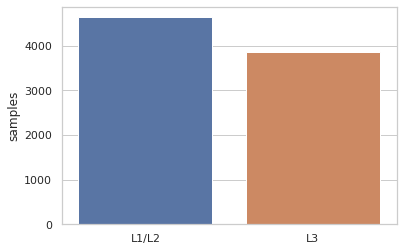

In [26]:
x=df_incidents_level.Target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

**Let use word cloud to visualize the type of words used in Description**


In [27]:
def f_word_cloud(column):
    
    comment_words = ' '
    stopwords = set(STOPWORDS)

    # iterate through the csv file 
    for val in column: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '


    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 
    
    return wordcloud

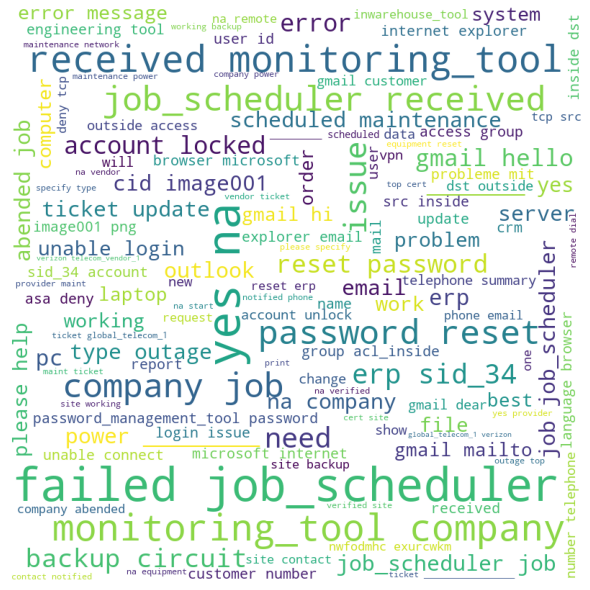

In [28]:
from wordcloud import WordCloud, STOPWORDS 


wordcloud = f_word_cloud(df2.New_Description)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Lets view the word cloud of top 4 assignment groups to see the kind of tickets assigned to them
Word Cloud for tickets starting with Assignment group 'GRP_0'

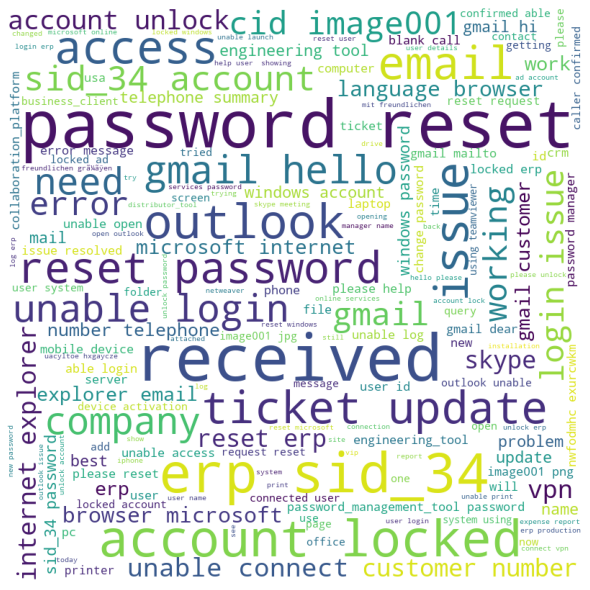

In [29]:
wordcloud = f_word_cloud(df2[df2['Assignment group']=='GRP_0'].New_Description)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

GRP_0 seems to have tickets related to password reset, access issues , login issue, connectivity issue etc..

**Word Cloud for tickets with Assignment group 'GRP_8'**

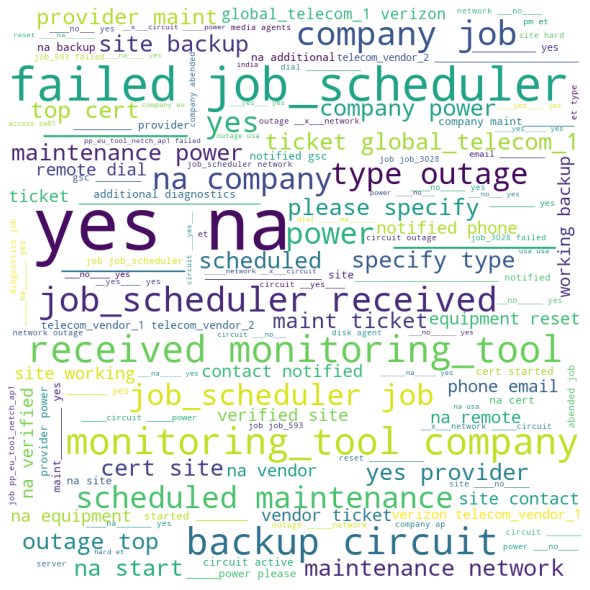

In [30]:
wordcloud = f_word_cloud(df2[df2['Assignment group']=='GRP_8'].New_Description)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

GRP_8 seems to have tickets related to outage, job failures, monitoring tool etc

**Word Cloud for tickets with Assignment group 'GRP_12'¶**

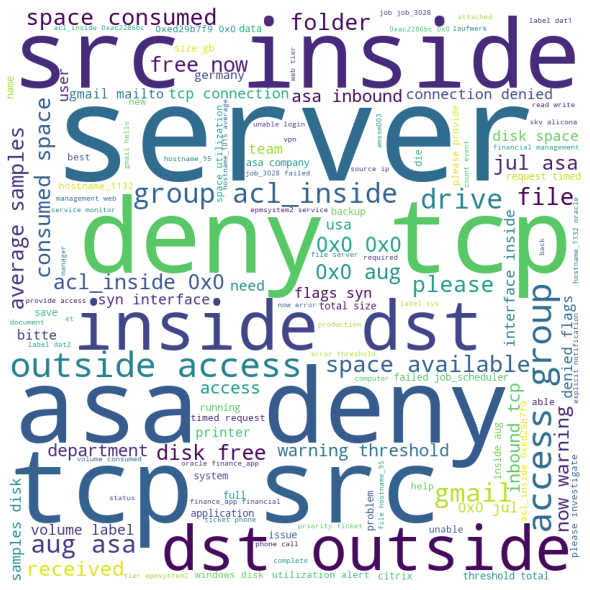

In [31]:
wordcloud = f_word_cloud(df2[df2['Assignment group']=='GRP_12'].New_Description)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

**Word Cloud for tickets with Assignment group 'GRP_24'**

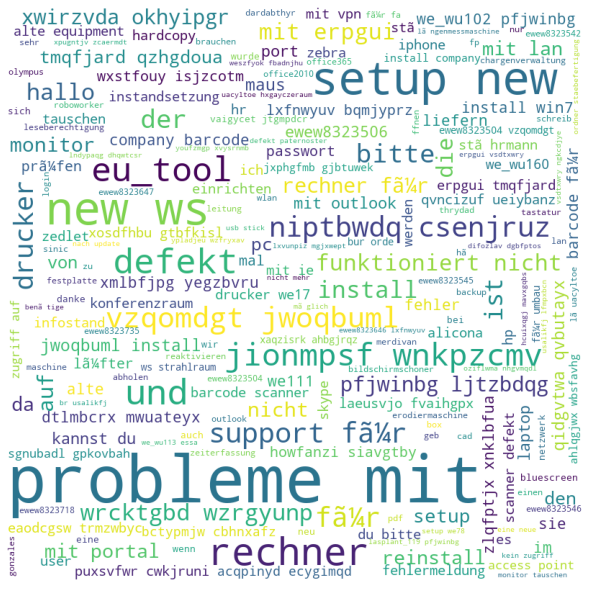

In [32]:
wordcloud = f_word_cloud(df2[df2['Assignment group']=='GRP_24'].New_Description)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

**Looks like tickets are in other language**

In [33]:
df2[df2['Assignment group']=='GRP_24'].New_Description

222     support fÃ¼r fa.gstry \arexjftu ohxdwngl suppo...
223     probleme mit bluescreen . hallo ,\n\nes ist er...
255     probleme mit laufwerk z: \laeusvjo fvaihgpx pr...
302     EU_tool ist sehr langsadgtym \ywqgrbnx jwnsyzb...
304     alte eq abholen \wrcktgbd wzrgyunp alte eq abh...
305     probleme lan an tgeyd1 \we_wu113 \wrcktgbd wzr...
306     support fÃ¼r we111\zlqfptjx xnklbfua support f...
349     install EU_tool \laeusvjo fvaihgpx install EU_...
441     probleme mit portal \knlrgsiv cqvuexjz problem...
446     setup rechner ewel8323865 fÃ¼r hr.thrydad (thr...
453     probleme mit erpgui \tmqfjard qzhgdoua problem...
454     support fÃ¼r fa.thrydsss-funke \laeusvjo fvaih...
455     bildband  tauschen \drucker we68678 \vepxdgot ...
555     probleme mit fixiereinheit we101 \qvncizuf uei...
586     probleme mit bluescreen  hallo ,\n\ngerade ebe...
589     probleme mit lan fÃ¼r rechner erodiermaschine\...
744     drucker in lÃ¶we uacyltoe hxgayczeraum knicrht...
748     reinst

In [34]:
#Lets encode the string, to make it easier to be passed to language detection api.
def fn_decode_to_ascii(df):
  text = df.encode().decode('utf-8').encode('ascii', 'ignore')
  return text.decode("utf-8") 

df2['New_Description'] = df2['New_Description'].apply(fn_decode_to_ascii)

**Detect the language the ticket is raised by**

In [35]:
pip install langdetect

In [36]:
from langdetect import detect
    
def fn_lan_detect(df):                                        
   try:                                                          
      return detect(df)                                      
   except:                                                       
      return 'no'                                                  

df2['language'] = df2['New_Description'].apply(fn_lan_detect)

In [37]:
df2["language"].value_counts()

en    7104
de     386
af     277
it     122
fr     111
no     105
nl      64
sv      54
es      51
ca      46
da      35
pl      31
pt      17
cy      17
ro      15
tl      12
et       9
sl       9
sq       7
hr       5
cs       5
fi       4
so       4
id       4
lt       2
sk       2
lv       1
vi       1
Name: language, dtype: int64

In [38]:
pip install googletrans

In [39]:
import googletrans
from googletrans import Translator
print(googletrans.LANGUAGES)

{'af': 'afrikaans', 'sq': 'albanian', 'am': 'amharic', 'ar': 'arabic', 'hy': 'armenian', 'az': 'azerbaijani', 'eu': 'basque', 'be': 'belarusian', 'bn': 'bengali', 'bs': 'bosnian', 'bg': 'bulgarian', 'ca': 'catalan', 'ceb': 'cebuano', 'ny': 'chichewa', 'zh-cn': 'chinese (simplified)', 'zh-tw': 'chinese (traditional)', 'co': 'corsican', 'hr': 'croatian', 'cs': 'czech', 'da': 'danish', 'nl': 'dutch', 'en': 'english', 'eo': 'esperanto', 'et': 'estonian', 'tl': 'filipino', 'fi': 'finnish', 'fr': 'french', 'fy': 'frisian', 'gl': 'galician', 'ka': 'georgian', 'de': 'german', 'el': 'greek', 'gu': 'gujarati', 'ht': 'haitian creole', 'ha': 'hausa', 'haw': 'hawaiian', 'iw': 'hebrew', 'he': 'hebrew', 'hi': 'hindi', 'hmn': 'hmong', 'hu': 'hungarian', 'is': 'icelandic', 'ig': 'igbo', 'id': 'indonesian', 'ga': 'irish', 'it': 'italian', 'ja': 'japanese', 'jw': 'javanese', 'kn': 'kannada', 'kk': 'kazakh', 'km': 'khmer', 'ko': 'korean', 'ku': 'kurdish (kurmanji)', 'ky': 'kyrgyz', 'lo': 'lao', 'la': 'lat

**Translate the text to English**


In [40]:
# Function to translate the text to english.
def fn_translate(df,lang):
  try:
    if lang == 'en':
        return df
    else:
        return translator.translate(df).text
  except:
    return df
    
    
df2['English_Description'] = df2.apply(lambda x: fn_translate(x['New_Description'], x['language']), axis=1)

**We mainly see that GRP_0 contains incidents related to account lockout, lets see if other groups also have incidents related to account lockout**

In [41]:
df2[df2["Short description"].str.contains("account lock")]["Assignment group"].value_counts()

GRP_0     226
GRP_2       3
GRP_34      1
GRP_72      1
Name: Assignment group, dtype: int64

**Data Cleaning**

In [42]:
import string
import re
from collections import Counter
from nltk.corpus import stopwords

In [43]:
df2.English_Description=df2.English_Description.astype(str)

In [44]:
### Make text lowercase, remove text in square brackets,remove links,remove punctuation and remove words containing numbers

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text=text.replace(('first name: ').lower(),'firstname')
    text=text.replace(('last name: ').lower(),'lastname')
    text=text.replace(('received from:').lower(),'')
    text=text.replace('email:','')
    text=text.replace('email address:','') 
    index1=text.find('from:')
    index2=text.find('\nsddubject:')
    text=text.replace(text[index1:index2],'')
    index3=text.find('[cid:image')
    index4=text.find(']')
    text=text.replace(text[index3:index4],'')
    text=text.replace('subject:','')
    text=text.replace('received from:','')
    text=text.replace('this message was sent from an unmonitored email address', '')
    text=text.replace('please do not reply to this message', '')
    text=text.replace('monitoring_tool@company.com','MonitoringTool')
    text=text.replace('select the following link to view the disclaimer in an alternate language','')
    text=text.replace('description problem', '') 
    text=text.replace('steps taken far', '')
    text=text.replace('customer job title', '')
    text=text.replace('sales engineer contact', '')
    text=text.replace('description of problem:', '')
    text=text.replace('steps taken so far', '')
    text=text.replace('please do the needful', '')
    text=text.replace('please note that ', '')
    text=text.replace('please find below', '')
    text=text.replace('date and time', '')
    text=text.replace('kindly refer mail', '')
    text=text.replace('name:', '')
    text=text.replace('language:', '')
    text=text.replace('customer number:', '')
    text=text.replace('telephone:', '')
    text=text.replace('summary:', '')
    text=text.replace('sincerely', '')
    text=text.replace('company inc', '')
    text=text.replace('importance:', '')
    text=text.replace('gmail.com', '')
    text=text.replace('company.com', '')
    text=text.replace('microsoftonline.com', '')
    text=text.replace('company.onmicrosoft.com', '')
    text=text.replace('hello', '')
    text=text.replace('hallo', '')
    text=text.replace('hi it team', '')
    text=text.replace('hi team', '')
    text=text.replace('hi', '')
    text=text.replace('best', '')
    text=text.replace('kind', '')
    text=text.replace('regards', '')
    text=text.replace('good morning', '')
    text=text.replace('please', '')
    text=text.replace('regards', '')

    text = re.sub(r'\S+@\S+', '', text)
    custom_punctuation='!"#$%&\'()*+,-./:;<=>?@[\\]^`{|}~'
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\r\n', '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\S+@\S+', '', text)

    text = text.lower()
    return text


In [45]:
df2['cleaned_description'] = df2['English_Description'].apply(lambda x: clean_text(x))
df2.drop(['English_Description'],axis=1,inplace=True)

In [46]:
df2['cleaned_description'].head()

0    login issue verified user detailsemployee  man...
1    outlook  hmjdrvpbkomuaywn teammy meetingsskype...
2    cant log in to vpn  eylqgodmybqkwiami cannot l...
3    unable to access hrtool page unable to access ...
4                            skype error  skype error 
Name: cleaned_description, dtype: object

**Removal of Stop Words**

Lets get rid of the stopwords i.e words which occur very frequently but have no possible value like a, an, the, are etc.

**Lemmatization**

In [47]:
## Lemmatization
import nltk
nltk.download('wordnet')

from textblob import Word
df2['cleaned_description']= df2['cleaned_description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in str(x).split()]))
df2['cleaned_description'].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    login issue verified user detailsemployee mana...
1    outlook hmjdrvpbkomuaywn teammy meetingsskype ...
2    cant log in to vpn eylqgodmybqkwiami cannot lo...
3    unable to access hrtool page unable to access ...
4                              skype error skype error
Name: cleaned_description, dtype: object

**Finally, let’s look at the most common words over the entire corpus.**

In [48]:
wd_counts = Counter()
for i, row in df2.iterrows():
    wd_counts.update(row['cleaned_description'].split())
    
wd_counts.most_common(20)

[('to', 8022),
 ('the', 6494),
 ('in', 4720),
 ('is', 3323),
 ('on', 2846),
 ('not', 2822),
 ('and', 2596),
 ('a', 2566),
 ('at', 2464),
 ('for', 2418),
 ('password', 2047),
 ('i', 1949),
 ('erp', 1935),
 ('jobscheduler', 1915),
 ('of', 1747),
 ('failed', 1706),
 ('yesnona', 1568),
 ('it', 1484),
 ('unable', 1474),
 ('reset', 1422)]

Tokenization

Tokenization is a process that splits an input sequence into so-called tokens where the tokens can be a word, sentence, paragraph etc.

In [49]:
import nltk
# Tokenizing the training and the test set
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
df2['token_desc'] = df2['cleaned_description'].apply(lambda x: tokenizer.tokenize(x))

In [50]:
df2['token_desc'].head()

0    [login, issue, verified, user, detailsemployee...
1    [outlook, hmjdrvpbkomuaywn, teammy, meetingssk...
2    [cant, log, in, to, vpn, eylqgodmybqkwiami, ca...
3    [unable, to, access, hrtool, page, unable, to,...
4                         [skype, error, skype, error]
Name: token_desc, dtype: object

In [51]:
# After preprocessing, the text format
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

df2['token_desc'] = df2['token_desc'].apply(lambda x : combine_text(x))

In [52]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Short description    8500 non-null   object
 1   Description          8500 non-null   object
 2   Assignment group     8500 non-null   object
 3   New_Description      8500 non-null   object
 4   language             8500 non-null   object
 5   cleaned_description  8500 non-null   object
 6   token_desc           8500 non-null   object
dtypes: object(7)
memory usage: 465.0+ KB


In [53]:
df_incidents_level.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8500 non-null   object
 1   Description        8500 non-null   object
 2   Assignment group   8500 non-null   object
 3   New_Description    8500 non-null   object
 4   Target             8500 non-null   object
dtypes: object(5)
memory usage: 332.2+ KB


**Transforming tokens to a vector using tfidf**

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

# word level tf-idf for ticket
tfidf = TfidfVectorizer(max_features=250, analyzer = 'word', min_df=2, max_df=0.95, ngram_range=(1, 2))
inc_tfidf = tfidf.fit_transform(df2['token_desc'])

In [55]:
#  create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(
                    dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

In [56]:
tfidf.sort_values(by=['tfidf'], ascending=True).head(10)

,tfidf
to,1.979536
in,2.193946
the,2.251881
is,2.522838
not,2.632764
on,2.702574
and,2.752204
at,2.784609
for,2.791642
it,3.088541


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


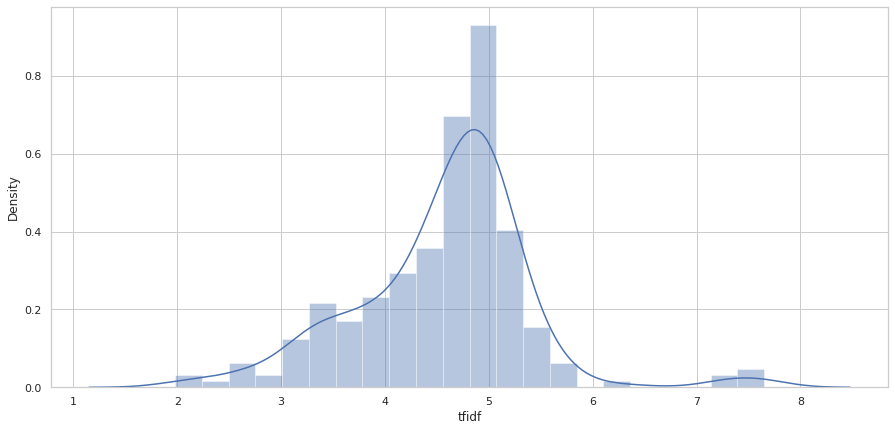

In [57]:
plt.figure(figsize=(15,7))
sns.distplot(tfidf["tfidf"])

Given the high dimension of our tfidf matrix, we need to reduce their dimension using the Singular Value Decomposition (SVD) technique. 

**Dimentionality reduction using t-SNE**

In [58]:
from sklearn.decomposition import TruncatedSVD

n_comp=10
svd = TruncatedSVD(n_components=n_comp, random_state=42)
svd_tfidf = svd.fit_transform(inc_tfidf)

In [59]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=42, n_iter=500)
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8500 samples in 0.029s...
[t-SNE] Computed neighbors for 8500 samples in 0.830s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8500
[t-SNE] Computed conditional probabilities for sample 2000 / 8500
[t-SNE] Computed conditional probabilities for sample 3000 / 8500
[t-SNE] Computed conditional probabilities for sample 4000 / 8500
[t-SNE] Computed conditional probabilities for sample 5000 / 8500
[t-SNE] Computed conditional probabilities for sample 6000 / 8500
[t-SNE] Computed conditional probabilities for sample 7000 / 8500
[t-SNE] Computed conditional probabilities for sample 8000 / 8500
[t-SNE] Computed conditional probabilities for sample 8500 / 8500
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.961510
[t-SNE] KL divergence after 500 iterations: 1.199084


In [60]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

**Modeling**

In [61]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier


from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [62]:
df_sample = df2[df2['Assignment group'].map(df2['Assignment group'].value_counts()) > 100]
x = df_sample['token_desc']
y = df_sample['Assignment group']

from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
# encoding train labels 
encoder.fit(y)
y = encoder.transform(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=13,stratify=y)


log_cols=["Classifier", "accuracy","f1_score"]
log = pd.DataFrame(columns=log_cols)

**Naive Bayes classifier for multinomial models**

In [63]:
from sklearn.feature_extraction.text import CountVectorizer

In [64]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [65]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

predictions = nb.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test)) 
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
print ("logloss: %0.3f " % multiclass_logloss(y_test,predictions))

print('classifcation report')
print(classification_report(y_test, y_pred))

print('confusion matrix ')
print(confusion_matrix(y_test,y_pred))


log_entry = pd.DataFrame([["MultinomialNB",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log = log.append(log_entry)

accuracy 0.6778093883357041
f1 score 0.7868469725888636
logloss: 1.561 
classifcation report
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       795
           1       0.00      0.00      0.00        28
           2       0.90      0.18      0.30        51
           3       0.00      0.00      0.00        29
           4       0.00      0.00      0.00        24
           5       0.00      0.00      0.00        43
           6       0.80      0.08      0.15        48
           7       0.92      0.38      0.54        58
           8       0.00      0.00      0.00        23
           9       0.00      0.00      0.00        40
          10       0.00      0.00      0.00        21
          11       0.00      0.00      0.00        26
          12       1.00      0.05      0.10        37
          13       0.55      0.92      0.68       132
          14       0.00      0.00      0.00        51

    accuracy                           0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Linear Support Vector Machine**

In [66]:
from sklearn.svm import LinearSVC

svc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', OneVsRestClassifier(LinearSVC(loss='hinge',random_state=42))),
               ])
svc.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 OneVsRestClassifier(estimator=LinearSVC(C=1.0,
                                                         class_weight=None,
             

In [67]:
y_pred = svc.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
#print (focal_loss(alpha=.25, gamma=2))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["LinearSVC",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log = log.append(log_entry)

accuracy 0.7439544807965861
f1 score 0.7609815441393735
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       795
           1       0.21      0.32      0.26        28
           2       0.65      0.51      0.57        51
           3       0.68      0.59      0.63        29
           4       0.64      0.29      0.40        24
           5       0.68      0.30      0.42        43
           6       0.81      0.44      0.57        48
           7       0.90      0.91      0.91        58
           8       1.00      0.48      0.65        23
           9       0.72      0.33      0.45        40
          10       0.70      0.33      0.45        21
          11       1.00      0.04      0.07        26
          12       0.19      0.73      0.30        37
          13       0.93      0.39      0.55       132
          14       0.89      0.16      0.27        51

    accuracy                           0.74      1406
   macro avg       0.72 

**Logistic regression**

In [68]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=100000.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

In [69]:
y_pred = logreg.predict(X_test)
predictions = logreg.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
print ("logloss: %0.3f " % multiclass_logloss(y_test,predictions))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["LogisticRegression",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log = log.append(log_entry)

accuracy 0.7645803698435277
f1 score 0.7873820003555778
logloss: 1.078 
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       795
           1       0.62      0.29      0.39        28
           2       0.60      0.47      0.53        51
           3       0.73      0.66      0.69        29
           4       0.41      0.29      0.34        24
           5       0.43      0.42      0.42        43
           6       0.65      0.58      0.62        48
           7       0.90      0.91      0.91        58
           8       0.76      0.57      0.65        23
           9       0.50      0.42      0.46        40
          10       0.58      0.33      0.42        21
          11       0.00      0.00      0.00        26
          12       0.91      0.27      0.42        37
          13       0.56      0.95      0.70       132
          14       0.85      0.22      0.34        51

    accuracy                           0.76      1406
   macro

**SGD Classifier**

In [70]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

In [71]:
y_pred = sgd.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 


print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["SGDClassifier",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log = log.append(log_entry)

accuracy 0.7233285917496444
f1 score 0.7970542857796487
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       795
           1       0.00      0.00      0.00        28
           2       0.62      0.25      0.36        51
           3       0.70      0.24      0.36        29
           4       0.40      0.08      0.14        24
           5       1.00      0.02      0.05        43
           6       0.89      0.33      0.48        48
           7       0.89      0.81      0.85        58
           8       1.00      0.22      0.36        23
           9       0.00      0.00      0.00        40
          10       1.00      0.10      0.17        21
          11       0.00      0.00      0.00        26
          12       0.38      0.41      0.39        37
          13       0.59      0.86      0.70       132
          14       1.00      0.08      0.15        51

    accuracy                           0.72      1406
   macro avg       0.61 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Xgboost**

In [72]:
import xgboost as xgb

xgboost = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)),
               ])
xgboost.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missi

In [73]:
y_pred = xgboost.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["Xgboost",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log = log.append(log_entry)

accuracy 0.7510668563300142
f1 score 0.7923786404225158
              precision    recall  f1-score   support

           0       0.80      0.97      0.88       795
           1       0.67      0.07      0.13        28
           2       0.59      0.43      0.50        51
           3       0.76      0.45      0.57        29
           4       0.50      0.21      0.29        24
           5       0.59      0.23      0.33        43
           6       0.81      0.44      0.57        48
           7       0.86      0.83      0.84        58
           8       1.00      0.48      0.65        23
           9       0.64      0.23      0.33        40
          10       0.53      0.43      0.47        21
          11       0.25      0.04      0.07        26
          12       0.92      0.30      0.45        37
          13       0.55      0.90      0.68       132
          14       0.75      0.12      0.20        51

    accuracy                           0.75      1406
   macro avg       0.68 

In [74]:
from sklearn.ensemble import RandomForestClassifier
rand_forest = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(max_depth=2, random_state=0))
               ])

rf=rand_forest.fit(X_train, y_train)
 

In [75]:
y_pred = rf.predict(X_test)
cm=confusion_matrix(y_test,y_pred)


In [76]:
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["RandomForestClassifier",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
print(accuracy_score(y_pred,y_test))
log = log.append(log_entry)

              precision    recall  f1-score   support

           0       0.58      1.00      0.73       795
           1       0.00      0.00      0.00        28
           2       0.00      0.00      0.00        51
           3       0.00      0.00      0.00        29
           4       0.00      0.00      0.00        24
           5       0.00      0.00      0.00        43
           6       0.00      0.00      0.00        48
           7       0.00      0.00      0.00        58
           8       0.00      0.00      0.00        23
           9       0.00      0.00      0.00        40
          10       0.00      0.00      0.00        21
          11       0.00      0.00      0.00        26
          12       0.00      0.00      0.00        37
          13       1.00      0.23      0.37       132
          14       0.00      0.00      0.00        51

    accuracy                           0.59      1406
   macro avg       0.11      0.08      0.07      1406
weighted avg       0.42   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
df_train, df_ = train_test_split(x, test_size=0.2, random_state=1, stratify=y)
df_valid, df_test = train_test_split(df_, test_size=0.5, random_state=1)
print("Train", df_train.shape, "| Validation", df_valid.shape, "| Test", df_test.shape)



Train (5624,) | Validation (703,) | Test (703,)


**Deep Neural Networks(NN)**

In [78]:
# Function to build Deep NN
def Build_Model_DNN_Text(shape, nClasses, dropout=0.3):
    """
    buildModel_DNN_Tex(shape, nClasses,dropout)
    Build Deep neural networks Model for text classification
    Shape is input feature space
    nClasses is number of classes
    """
    model = Sequential()
    node = 512 # number of nodes
    nLayers = 4 # number of  hidden layer
    model.add(Dense(node,input_dim=shape,activation='relu'))
    model.add(Dropout(dropout))
    for i in range(0,nLayers):
        model.add(Dense(node,input_dim=node,activation='relu'))
        model.add(Dropout(dropout))
        model.add(BatchNormalization())
    model.add(Dense(nClasses, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    print(model.summary())
    return model

Generate Dataset for createing 2 models

Model 1 : Group 0 & all other groups combined to "other"

Model 2 : Group 0 removed & only includes other groups

Model 1 will be use dto classing group 0. 
If not found to be Group 0, we can classify using Model 2.

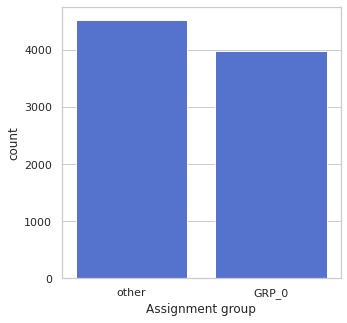

In [79]:
# Create the Dataset for classifying GRP_0
itTicketGRP0DF = df2.copy()
itTicketGRP0DF['Assignment group']=itTicketGRP0DF['Assignment group'].apply(lambda x : 'other' if x != 'GRP_0'  else x)

descending_order = itTicketGRP0DF['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(5,5))
sns.countplot(x='Assignment group', data=itTicketGRP0DF, color='royalblue',order=descending_order)

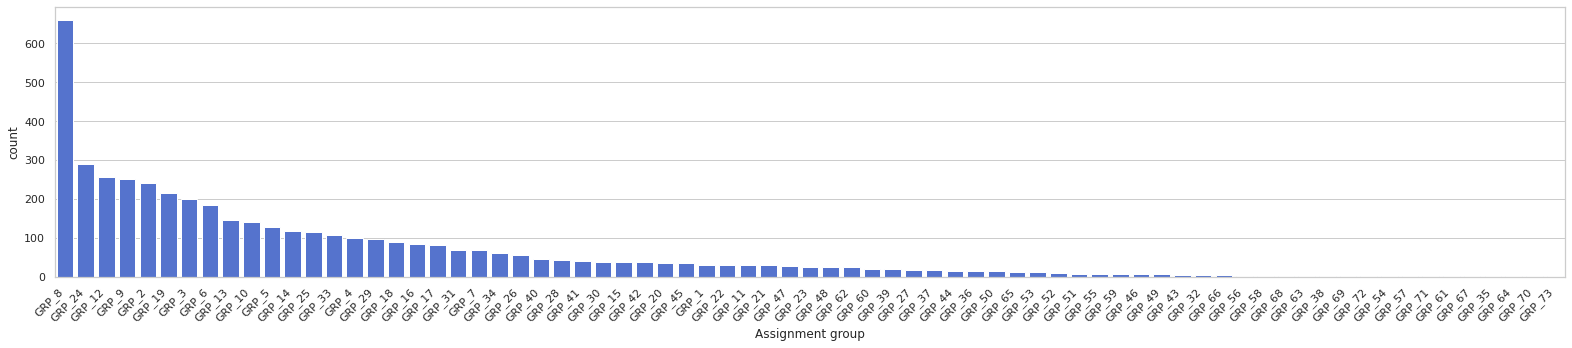

In [80]:
#Create Dataset for 'others' i.e all groups which is not part of GRP_0
itTicketOthersDF = df2[df2['Assignment group'] != 'GRP_0']

descending_order = itTicketOthersDF['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#add code to rotate the labels
ax=sns.countplot(x='Assignment group', data=itTicketOthersDF, color='royalblue',order=descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [81]:
maxOthers = itTicketOthersDF['Assignment group'].value_counts().max()
maxOthers

661

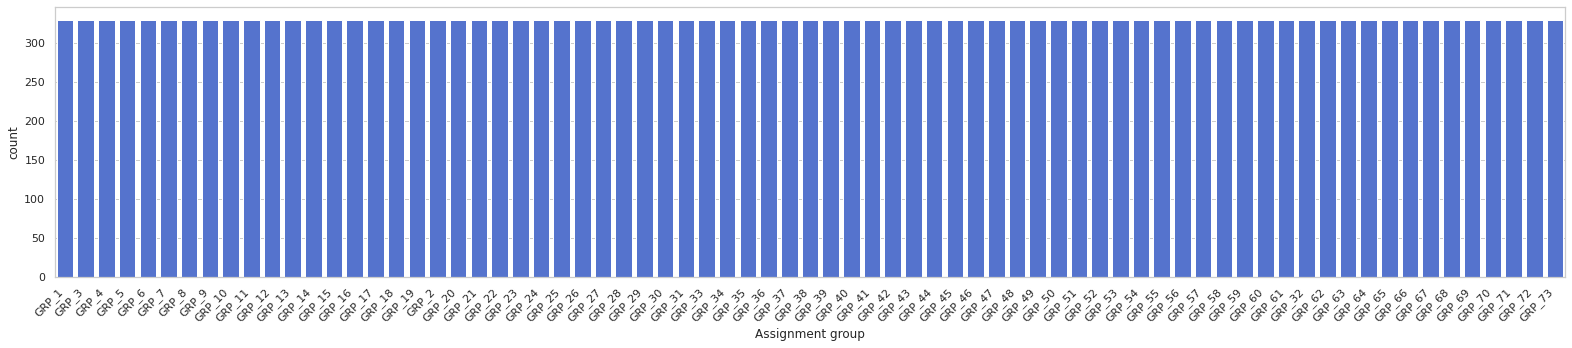

In [82]:
# Treat the imbalnce in the 'other' dataset by resampling
from sklearn.utils import resample
itTicketOthersDF_resampled = itTicketOthersDF[0:0]
for grp in itTicketOthersDF['Assignment group'].unique():
    itTicketGrpDF = itTicketOthersDF[itTicketOthersDF['Assignment group'] == grp]
    resampled = resample(itTicketGrpDF, replace=True, n_samples=int(maxOthers/2), random_state=123)
    itTicketOthersDF_resampled = itTicketOthersDF_resampled.append(resampled)

otherGrpsResampled = pd.concat([itTicketGRP0DF,itTicketOthersDF_resampled])
otherGrpsResampled.reset_index(inplace=True)

descending_order = itTicketOthersDF_resampled['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#add code to rotate the labels
ax=sns.countplot(x='Assignment group', data=itTicketOthersDF_resampled, color='royalblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

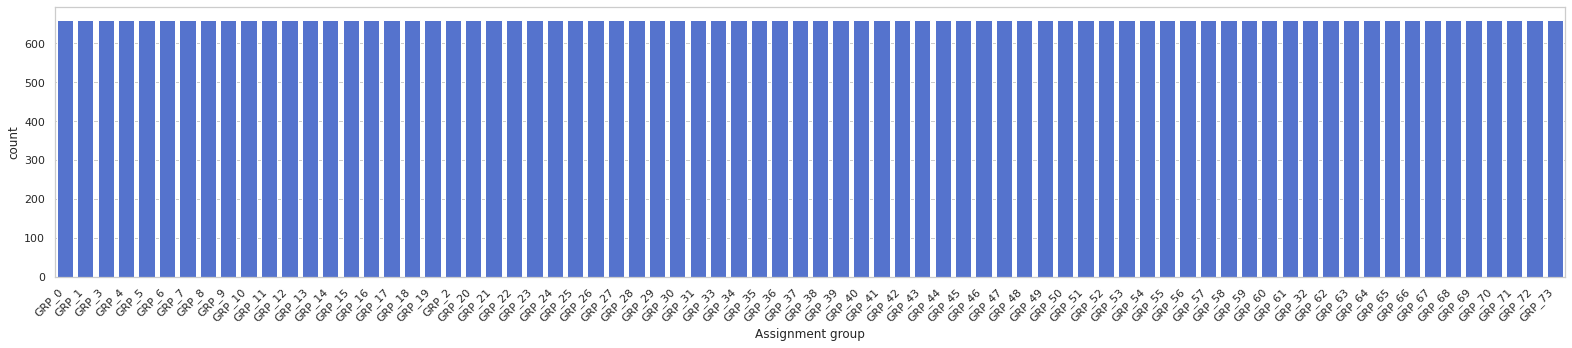

In [83]:
# Treat the imbalnce in the itTicketDF dataset by resampling to 661.This is for us to try creating a single model which use the whiole dataset & verify the performance
itTicketDF_resampled = df2[0:0]
for grp in df2['Assignment group'].unique():
    itTicketGrpDF = df2[df2['Assignment group'] == grp]
    resampled = resample(itTicketGrpDF, replace=True, n_samples=int(maxOthers), random_state=123)
    itTicketDF_resampled = itTicketDF_resampled.append(resampled)

descending_order = itTicketDF_resampled['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#add code to rotate the labels
ax=sns.countplot(x='Assignment group', data=itTicketDF_resampled, color='royalblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

**Label Encoding 'Assignment group' target class**

In [84]:
from sklearn import preprocessing
def labelencoder(dataframe) : 
  label_encoder = preprocessing.LabelEncoder() 
  dataframe= label_encoder.fit_transform(dataframe)
  grp_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
  return dataframe,grp_mapping

#itTicketGRP0DF['Assignment group'] , grp_mapping_grp0= labelencoder(itTicketGRP0DF['Assignment group'])
#itTicketOthersDF_resampled['Assignment group'] , grp_mapping_others_resampled= labelencoder(itTicketOthersDF_resampled['Assignment group'])
otherGrpsResampled['Assignment group'] , grp_mapping_others_resampled= labelencoder(otherGrpsResampled['Assignment group'])
itTicketDF_resampled['Assignment group'] , grp_mapping_all_resampled= labelencoder(itTicketDF_resampled['Assignment group'])
df2['Assignment group'],grp_mapping_all_raw = labelencoder(df2['Assignment group'])

**Modelling**

In [85]:
from gensim.models import Word2Vec
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D,GRU,Conv1D,MaxPooling1D
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf
from sklearn import metrics
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

**Word2Vec embedding**

In [86]:
sentences = [line.split(' ') for line in df2['Description']]
word2vec = Word2Vec(sentences=sentences,min_count=1)
word2vec.wv.save_word2vec_format('word2vec_vector.txt')

In [87]:
# Add Function to capture results from each model 
import operator
def captureData(dataframe,modelHistory,modelName,descriptions,index_df,resetData):
  if resetData == 1:
    tempResultsDf=pd.DataFrame()
    dataframe=pd.DataFrame()
  else:
    index, acc_value = max(enumerate(modelHistory.history['val_accuracy']), key=operator.itemgetter(1))
    tempResultsDf= pd.DataFrame(
      {'model':[modelName], 
      'val_accuracy': [acc_value],
      'val_loss':[modelHistory.history['val_loss'][index]],
      'loss':[modelHistory.history['loss'][index]],
      'accuracy':[modelHistory.history['accuracy'][index]],
      'descriptions':[descriptions]},index={str(index_df)})
    dataframe = pd.concat([dataframe,tempResultsDf])
    dataframe = dataframe[['model','val_accuracy' ,'val_loss','loss','accuracy','descriptions']] 
  return dataframe

def capturePrediction(dataframe,modelName,descriptions,index_df,pred_accuracy,resetData):
  if resetData == 1:
    tempResultsDf=pd.DataFrame()
    dataframe=pd.DataFrame()
  else:
    tempResultsDf= pd.DataFrame(
      {'model':[modelName], 
      'Pred_Accuracy' : [pred_accuracy],
      'descriptions':[descriptions]},index={str(index_df)})
    dataframe = pd.concat([dataframe,tempResultsDf])
    dataframe = dataframe[['model','Pred_Accuracy','descriptions']] 
  return dataframe

In [88]:
maxlen = 300
numWords=9000
epochs = 10

In [89]:
results=pd.DataFrame()
pred_results = pd.DataFrame()

In [90]:
class LstmModel:
  model= Model()
  X_test=[]
  y_test=[]
  embedding_matrix=[]

  def wordTokenizer(self, dataframe):
    tokenizer = Tokenizer(num_words=numWords,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ', char_level=False)
    tokenizer.fit_on_texts(dataframe)
    dataframe = tokenizer.texts_to_sequences(dataframe)
    return tokenizer,dataframe
  
  def splitData(self,X,y):

    print("Number of Samples:", len(X))
    print("Number of Labels: ", len(y))
    X_train, self.X_test, y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=10) # changed by Abraham
    X_train, X_Val, y_train, y_Val = train_test_split(X, y, test_size=0.2, random_state=10)
    print("Number of train Samples:", len(X_train))
    print("Number of val Samples:", len(X_Val))

    return X_train, self.X_test, y_train, self.y_test, X_Val, y_Val

  def tokenizeAndEmbedding(self,dataframe):
    
    tokenizer,X = self.wordTokenizer(dataframe['Description'])
    y = np.asarray(dataframe['Assignment group'])
    X = pad_sequences(X, maxlen = maxlen)

    self.embedding_matrix = np.zeros((numWords+1, 100))
    for i,word in tokenizer.index_word.items():
      if i<numWords+1:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            self.embedding_matrix[i] = embedding_vector
    return X,y

  def train(self, dataframe, batch_size, epochs):
   
    X,y = self.tokenizeAndEmbedding(dataframe)
    X_train, _, y_train, _, X_Val, y_Val = self.splitData(X,y)
    model_history = self.fitModel(X_train,y_train,X_Val,y_Val,batch_size, epochs)
    return model_history

  def fitModel(self,X_train,y_train,X_Val,y_Val,batch_size, epochs):
    
    input_layer = Input(shape=(maxlen,),dtype=tf.int64)
    embed = Embedding(numWords+1,output_dim=100,input_length=maxlen,weights=[self.embedding_matrix], trainable=True)(input_layer)  #weights=[embedding_matrix]
    lstm=Bidirectional(LSTM(128))(embed)
    drop=Dropout(0.3)(lstm)
    dense =Dense(100,activation='relu')(drop)
    out=Dense(len((pd.Series(y_train)).unique()),activation='softmax')(dense)   

    self.model = Model(input_layer,out)
    self.model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

    self.model.summary()
    plot_model(self.model,to_file="LSTM_Model.jpg")

    checkpoint = ModelCheckpoint('model-{epoch:03d}-{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto') 
    reduceLoss = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
    model_history = self.model.fit(X_train,y_train,batch_size=batch_size, epochs=epochs, callbacks=[checkpoint,reduceLoss], validation_data=(X_Val,y_Val))

    return model_history,self.model

  def prediction(self):
      
     pred = self.model.predict(self.X_test)
     pred = [i.argmax() for i in pred]
     accuracy = metrics.accuracy_score(self.y_test, pred)
     print("Accuracy of the model :",metrics.accuracy_score(self.y_test, pred))
     return accuracy

  def plotModelAccuracy(self, history, modelname):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title(modelname+' model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title(modelname+' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

In [91]:
gloveFileName = 'glove.6B.200d.txt'
MAX_SEQUENCE_LENGTH = 500
EMBEDDING_DIM=200
MAX_NB_WORDS=75000

# Function to generate Embedding
def loadData_Tokenizer(X_train, X_test,filename):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train = text[0:len(X_train), ]
    X_test = text[len(X_train):, ]
    embeddings_index = {}
    f = open(filename, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_index))
    return (X_train, X_test, word_index,embeddings_index)


embedding_matrix = []

def buildEmbed_matrices(word_index,embedding_dim):
    embedding_matrix = np.random.random((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) !=len(embedding_vector):
                print("could not broadcast input array from shape",str(len(embedding_matrix[i])), "into shape",str(len(embedding_vector)),
                      " Please make sure your"" EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [92]:
# Generate Glove embedded datasets
X_train_Glove, X_test_Glove, word_index, embeddings_index = loadData_Tokenizer(X_train,X_test,gloveFileName)
embedding_matrix = buildEmbed_matrices(word_index,EMBEDDING_DIM)

Found 13306 unique tokens.
(7030, 500)
Total 400000 word vectors.


In [93]:
def Build_Model_CNN_Text(word_index, embeddings_matrix, nclasses,dropout=0.5):
    """
        def buildModel_CNN(word_index, embeddings_index, nclasses, MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
        word_index in word index ,
        embeddings_index is embeddings index, look at data_helper.py
        nClasses is number of classes,
        MAX_SEQUENCE_LENGTH is maximum lenght of text sequences,
        EMBEDDING_DIM is an int value for dimention of word embedding look at data_helper.py
    """
    model = Sequential()
    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embeddings_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True)
    # applying a more complex convolutional approach
    convs = []
    filter_sizes = []
    layer = 5
    print("Filter  ",layer)
    for fl in range(0,layer):
        filter_sizes.append((fl+2))
    node = 128
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    for fsz in filter_sizes:
        l_conv = Conv1D(node, kernel_size=fsz, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(5)(l_conv)
        #l_pool = Dropout(0.25)(l_pool)
        convs.append(l_pool)
    l_merge = Concatenate(axis=1)(convs)
    l_cov1 = Conv1D(node, 5, activation='relu')(l_merge)
    l_cov1 = Dropout(dropout)(l_cov1)
    l_batch1 = BatchNormalization()(l_cov1)
    l_pool1 = MaxPooling1D(5)(l_batch1)
    l_cov2 = Conv1D(node, 5, activation='relu')(l_pool1)
    l_cov2 = Dropout(dropout)(l_cov2)
    l_batch2 = BatchNormalization()(l_cov2)
    l_pool2 = MaxPooling1D(30)(l_batch2)
    l_flat = Flatten()(l_pool2)
    l_dense = Dense(1024, activation='relu')(l_flat)
    l_dense = Dropout(dropout)(l_dense)
    l_dense = Dense(512, activation='relu')(l_dense)
    l_dense = Dropout(dropout)(l_dense)
    preds = Dense(nclasses, activation='softmax')(l_dense)
    model = Model(sequence_input, preds)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    print(model.summary())
    return model

In [94]:
import keras.backend as K
from keras.datasets import imdb
from keras.models import Sequential, Model
from keras.layers.merge import Concatenate
from keras.layers import Input, Dropout, Flatten, Dense, Embedding, LSTM, GRU
from keras.layers import BatchNormalization, TimeDistributed, Conv1D, MaxPooling1D
from keras.constraints import max_norm, unit_norm
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [95]:
from time import time

In [96]:
# A class that logs the time
class Timer():
    '''
    A generic class to log the time
    '''
    def __init__(self):
        self.start_ts = None
    def start(self):
        self.start_ts = time()
    def stop(self):
        return 'Time taken: %2fs' % (time()-self.start_ts)
    
timer = Timer()

# A method that plots the Precision-Recall curve
def plot_prec_recall_vs_thresh(precisions, recalls, thresholds):
    plt.figure(figsize=(10,5))
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend()

# A method to train and test the model
def run_classification(estimator, X_train, X_test, y_train, y_test, arch_name=None, pipelineRequired=True, isDeepModel=False):
    timer.start()
    # train the model
    clf = estimator

    if pipelineRequired :
        clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', estimator),
                     ])
      
    if isDeepModel :
        clf.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=10, batch_size=128,verbose=1,callbacks=call_backs(arch_name))
        # predict from the claffier
        y_pred = clf.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
        y_train_pred = clf.predict(X_train)
        y_train_pred = np.argmax(y_train_pred, axis=1)
    else :
        clf.fit(X_train, y_train)
        # predict from the claffier
        y_pred = clf.predict(X_test)
        y_train_pred = clf.predict(X_train)
    
    print('Estimator:', clf)
    print('='*80)
    print('Training accuracy: %.2f%%' % (accuracy_score(y_train,y_train_pred) * 100))
    print('Testing accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))
    print('='*80)
    print('Confusion matrix:\n %s' % (confusion_matrix(y_test, y_pred)))
    print('='*80)
    print('Classification report:\n %s' % (classification_report(y_test, y_pred)))
    print(timer.stop(), 'to run the model')

In [99]:
#Path where you want to save the weights, model and checkpoints
model_path = "Weights/"
#%mkdir Weights

# Define model callbacks
def call_backs(name):
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=100)
    model_checkpoint =  ModelCheckpoint(model_path + name + '_epoch{epoch:02d}_loss{val_loss:.4f}.h5',
                                                               monitor='val_loss',
                                                               verbose=1,
                                                               save_best_only=True,
                                                               save_weights_only=False,
                                                               mode='min',
                                                               period=1)
    return [model_checkpoint, early_stopping]

In [100]:
# Train the network and run classification
model_CNN = Build_Model_CNN_Text(word_index,embedding_matrix, 75)
run_classification(model_CNN, X_train_Glove, X_test_Glove, y_train, y_test,pipelineRequired = False,isDeepModel=True, arch_name='CNN')

Filter   5
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 500, 200)     2661400     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 499, 128)     51328       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 498, 128)     76928       embedding_1[0][0]                
_________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [101]:
def Build_Model_RCNN_Text(word_index, embeddings_matrix, nclasses):
    kernel_size = 2
    filters = 256
    pool_size = 2
    gru_node = 256
    
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embeddings_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(LSTM(gru_node, recurrent_dropout=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(Dense(1024,activation='relu'))
    model.add(Dense(nclasses))
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    
    print(model.summary())
    return model

In [102]:
# Train the network and run classification
model_RCNN = Build_Model_CNN_Text(word_index,embedding_matrix, 75)
run_classification(model_RCNN, X_train_Glove, X_test_Glove, y_train, y_test,pipelineRequired = False,isDeepModel=True, arch_name='RCNN')

Filter   5
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 500, 200)     2661400     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 499, 128)     51328       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 498, 128)     76928       embedding_2[0][0]                
_________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**RNN with LSTM networks¶**

In [103]:
EMBEDDING_DIM = 200


from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, Activation
from keras.layers import Flatten, Permute, merge, Input
from keras.layers import Embedding
from keras.models import Model
from keras.layers import Input, Dense, multiply, concatenate, Dropout
from keras.layers import GRU, Bidirectional


def Build_Model_LTSM_Text(word_index, embeddings_matrix, nclasses):
    kernel_size = 2
    filters = 256
    pool_size = 2
    gru_node = 256
    
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embeddings_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Bidirectional(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2)))
    model.add(Bidirectional(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2)))
    model.add(Bidirectional(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2)))
    model.add(Bidirectional(LSTM(gru_node, recurrent_dropout=0.2)))
    model.add(Dense(1024,activation='relu'))
    model.add(Dense(nclasses))
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    print(model.summary())
    return model

In [104]:
X_train_Glove,X_test_Glove, word_index,embeddings_index = loadData_Tokenizer(X_train,X_test,gloveFileName)
embedding_matrix = buildEmbed_matrices(word_index,EMBEDDING_DIM)

model_LTSM = Build_Model_LTSM_Text(word_index,embedding_matrix, 75)
run_classification(model_LTSM, X_train_Glove, X_test_Glove, y_train, y_test,pipelineRequired = False,isDeepModel=True, arch_name='LSTM')

Found 13306 unique tokens.
(7030, 500)
Total 400000 word vectors.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 200)          2661400   
_________________________________________________________________
dropout_12 (Dropout)         (None, 500, 200)          0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 499, 256)          102656    
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 249, 256)          0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 248, 256)          131328    
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 124, 256)          0         
______________________________________________________

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
